In [11]:
# ===========================
# Cell 0 — Config
# ===========================
DATA_ID = 'mackey_glass_tau17_n200'   # your dataset folder name

# Noise used in training & scoring
EVAL_SIGMA   = 0.20

# Windowing (must match qubit count for our half-QAE)
wind_size    = 4      # == n_qubits
wind_step    = 1

# Train/Test split on windows produced from the full series
split        = 0.75   # first 75% windows → train, last 25% → test

# Runs
INSTANCE_IDS = [1]    # start with 1 for quick sanity (can expand to [1,2,3,4,5])
LAYER_OPTIONS = [1, 3]  # Stage-1/3 depth options

# Logging
LOG_NAME = 'aintern'
CASE_NAME = 'half_qae'
DATA_PATH = f'{LOG_NAME}/data'
FIGURES_PATH = f'{LOG_NAME}/figures'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'

In [12]:
# ===========================
# Cell 1 — Imports & utils
# ===========================
import os, sys, time, math, random, json
from pathlib import Path
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt

# repo utils
sys.path.append('.'); sys.path.append('..')
from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg
from qae_utils.Window import ts_add_noise
from qae_utils.Charts import multi_plot_flat_ts

# folders
for p in [FIGURES_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH]:
    create_folder_if_needed(p)

# plotting
np.set_printoptions(suppress=True, precision=6)
plt.rcParams["figure.figsize"] = (6.5, 4)

def set_global_seed(instance_id: int):
    base = 10_000 + int(instance_id)
    random.seed(base + 11)
    np.random.seed(base + 22)
    try:
        pnp.random.seed(base + 33)
    except Exception:
        pass
    return dict(global_seed=base, numpy_seed=base+22, pnp_seed=base+33)

Using data folder: ../jacobs_examples/aintern/data/mackey_glass_tau17_n200
Loaded 200 samples; scale = [0.200, 0.800]


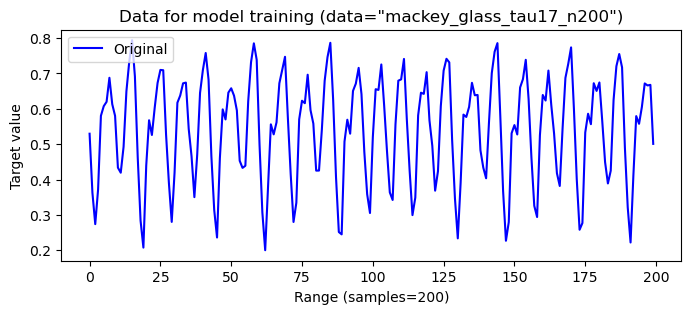

In [13]:
# ===========================
# Cell 2 — Load data & embed (robust paths)
# ===========================
import os

# keep your DATA_ID, LOG_NAME, DATA_PATH from Cell 0
# this resolver tries several roots so relative paths won't break
def _find_data_folder(data_id, log_name='aintern', preferred_root=None):
    candidates = []
    if preferred_root:
        candidates.append(preferred_root)
    # common locations
    candidates += [
        f'./{log_name}/data',
        f'../{log_name}/data',
        f'../../{log_name}/data',
        './jacobs_examples/aintern/data',
        '../jacobs_examples/aintern/data',
        '../../jacobs_examples/aintern/data',
    ]
    tried = []
    for root in candidates:
        folder = os.path.join(root, data_id)
        info_p = os.path.join(folder, 'info.json')
        x_p    = os.path.join(folder, 'x_org.arr')
        y_p    = os.path.join(folder, 'y_org.arr')
        tried.append(folder)
        if os.path.isdir(folder) and all(os.path.exists(p) for p in (info_p, x_p, y_p)):
            return folder
    raise FileNotFoundError(
        "Could not find dataset folder with required files.\n"
        f"DATA_ID='{data_id}'. Tried:\n - " + "\n - ".join(tried)
    )

# resolve the folder (uses your DATA_PATH from Cell 0 as a preference)
try:
    DATA_FOLDER = _find_data_folder(DATA_ID, log_name=LOG_NAME, preferred_root=DATA_PATH)
except Exception as e:
    # last resort: try without preferred_root
    DATA_FOLDER = _find_data_folder(DATA_ID, log_name=LOG_NAME, preferred_root=None)

data_info_path = f'{DATA_FOLDER}/info.json'
x_org_path     = f'{DATA_FOLDER}/x_org.arr'
y_org_path     = f'{DATA_FOLDER}/y_org.arr'

info = read_json_file(data_info_path)
X = read_ts_file(x_org_path).astype(int)  # indices (for plotting only)
y = read_ts_file(y_org_path)              # values (original domain)

scale_low  = float(info['scale_low'])
scale_high = float(info['scale_high'])
print(f'Using data folder: {DATA_FOLDER}')
print(f'Loaded {len(y)} samples; scale = [{scale_low:.3f}, {scale_high:.3f}]')

# quick plot (optional)
multi_plot_flat_ts([y], X_list=[0], colors=['blue'], labels=['Original'],
                   lines=['solid'], legend_cols=1, rcParams=(8, 3),
                   xlabel=f'Range (samples={len(y)})',
                   title=f'Data for model training (data=\"{DATA_ID}\")')

def embed_input(x, info_=None):
    """Map window values to RY(π·v01) with v01 from [scale_low, scale_high] → [0,1]."""
    if info_ is None: info_ = info
    lo, hi = float(info_['scale_low']), float(info_['scale_high'])
    xn = (pnp.array(x) - lo) / max(hi - lo, 1e-12)
    for i, v in enumerate(xn):
        qml.RY(v * pnp.pi, wires=i)

In [14]:
# ===========================
# Cell 3 — Architecture
# ===========================
n_qubits = wind_size      # must equal window size
n_latent = 2
n_trash  = n_qubits - n_latent
trash_wires  = list(range(n_latent, n_qubits))  # [2,3] for 4q
signal_wires = list(range(n_qubits))            # diagnostics / full outputs

def make_device(nq):
    return qml.device('default.qubit', wires=nq)

def encoder_template(params, n_layers):
    """RX/RY/RZ per qubit + ring CNOT per layer (same as your half-QAE)."""
    assert len(params) == n_layers * n_qubits * 3
    for l in range(n_layers):
        for q in range(n_qubits):
            idx = l * n_qubits * 3 + q * 3
            qml.RX(params[idx + 0], wires=q)
            qml.RY(params[idx + 1], wires=q)
            qml.RZ(params[idx + 2], wires=q)
        for q in range(n_qubits-1):
            qml.CNOT(wires=[q, q+1])
        qml.CNOT(wires=[n_qubits-1, 0])

print(f"Architecture set: {n_qubits}q ({n_latent} latent, {n_trash} trash).")

Architecture set: 4q (2 latent, 2 trash).


In [15]:
# ===========================
# Cell 4 — Stage-1 training
# ===========================
def stage1_qnodes(n_layers):
    dev = make_device(n_qubits)

    @qml.qnode(dev, interface="autograd", diff_method="backprop")
    def trash_expectations(phi, x_clean):
        embed_input(x_clean)
        encoder_template(phi, n_layers)
        return [qml.expval(qml.PauliZ(w)) for w in trash_wires]

    return trash_expectations

def stage1_loss_on_windows(trash_expect, phi, windows_clean):
    # P(|1>) = (1 - Z)/2 on trash wires
    total = pnp.array(0.0)
    for w in windows_clean:
        z = pnp.array(trash_expect(phi, w))
        total = total + pnp.mean((1.0 - z) * 0.5)
    return total / max(len(windows_clean), 1)

def train_stage1_clean(windows_train_clean, n_layers, instance_id,
                       n_epochs=120, lr_init=0.010, patience=10, lr_patience=8):
    set_global_seed(instance_id)
    enc_shape = n_layers * n_qubits * 3
    phi = pnp.array(np.random.normal(0, 0.5, enc_shape), requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=lr_init)
    lr = lr_init

    trash_expect = stage1_qnodes(n_layers)
    best_phi, best_cost = None, float("inf")
    no_improve = 0

    for ep in range(n_epochs):
        loss_fn = lambda p: stage1_loss_on_windows(trash_expect, p, windows_train_clean)
        phi, cost = opt.step_and_cost(loss_fn, phi)

        if cost < best_cost - 1e-9:
            best_cost, best_phi, no_improve = float(cost), pnp.array(phi, requires_grad=False), 0
        else:
            no_improve += 1
            if (no_improve % lr_patience) == 0:
                lr = max(lr * 0.5, 1e-4)
                opt = qml.AdamOptimizer(stepsize=lr)
                print(f"[Stage1] ↓ LR → {lr:.5f}")
            if no_improve >= patience:
                print("[Stage1] Early stopping."); break

        if ep % 5 == 0 or ep == n_epochs-1:
            print(f"[Stage1] L={n_layers} ep {ep:03d} | train {float(cost):.6f} | LR {lr:.5f}")

    return dict(phi=(best_phi if best_phi is not None else phi),
                best_train=float(best_cost))

In [16]:
# ===========================
# Cell 5 — Stage-3 QNodes
# ===========================
def stage3_qnodes(n_layers, phi_stage1):
    dev3 = make_device(n_qubits)
    theta_fixed = pnp.array(phi_stage1, requires_grad=False).reshape((n_layers, n_qubits, 3))

    def encoder_fixed_body(theta):
        for l in range(n_layers):
            for q in range(n_qubits):
                qml.RX(theta[l, q, 0], wires=q)
                qml.RY(theta[l, q, 1], wires=q)
                qml.RZ(theta[l, q, 2], wires=q)
            for q in range(n_qubits-1):
                qml.CNOT(wires=[q, q+1])
            qml.CNOT(wires=[n_qubits-1, 0])

    def decoder_fixed():
        qml.adjoint(encoder_fixed_body)(theta_fixed)

    @qml.qnode(dev3, interface="autograd", diff_method="backprop")
    def encoder_only_expZ_all(flat_params, x_in):
        embed_input(x_in)                      # noisy or clean, as passed
        encoder_template(flat_params, n_layers)
        return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

    @qml.qnode(dev3, interface="autograd", diff_method="backprop")
    def teacher_code_latents(x_clean):
        embed_input(x_clean)
        encoder_fixed_body(theta_fixed)        # fixed φ encoder
        return [qml.expval(qml.PauliZ(w)) for w in range(n_latent)]

    @qml.qnode(dev3, interface="autograd", diff_method="backprop")
    def denoiser_qnode_all(flat_params, x_noisy):
        embed_input(x_noisy)
        encoder_template(flat_params, n_layers)
        decoder_fixed()                        # fixed φ decoder
        return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

    return dict(
        theta_fixed=theta_fixed,
        encoder_only_expZ_all=encoder_only_expZ_all,
        teacher_code_latents=teacher_code_latents,
        denoiser_qnode_all=denoiser_qnode_all
    )

def Z_to_values_autograd(z_all):
    z_all = pnp.clip(pnp.asarray(z_all), -0.999999, 0.999999)
    v01   = pnp.arccos(z_all) / pnp.pi
    return v01 * (scale_high - scale_low) + scale_low

def first_diff(x):
    x = pnp.array(x); return x[1:] - x[:-1]

def p1_from_expZ(z):
    return (1 - pnp.asarray(z)) * 0.5

def huber(residual, delta):
    r = pnp.abs(residual)
    return pnp.where(r <= delta, 0.5*r**2, delta*(r - 0.5*delta))

In [ ]:
# ===========================
# Cell 6 — Noise & scoring helpers
# ===========================
def make_windows_from_series(y_vec, noise_sigma, seed, wind_size, wind_step):
    """
    Inject one noise vector into the whole series,
    then windowize both clean and noisy series the same way.
    """
    y_noisy = ts_add_noise(y_vec, noise=noise_sigma, noise_type='normal', clip=False,
                           range_low=scale_low, range_high=scale_high, seed=seed)

    win_clean = ts_wind_make(y_vec,   wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)

    # windows index array (not used by model, only for split helper)
    X_ts = np.array([i*wind_step for i in range(len(win_clean))])

    # split consistently
    X_tr, y_tr_clean, X_te, y_te_clean = ts_wind_split(X_ts, win_clean, split)
    X_tr, y_tr_noisy, X_te, y_te_noisy = ts_wind_split(X_ts, win_noisy, split)

    return (y_tr_clean, y_tr_noisy, y_te_clean, y_te_noisy)

def denoise_windows(params, denoise_qnode, windows_noisy):
    outs = []
    for w in windows_noisy:
        zD = pnp.array(denoise_qnode(params, w))
        outs.append(pnp.array(Z_to_values_autograd(zD)))
    return pnp.stack(outs)

def mse_on_windows(w_true, w_pred):
    w_true = np.asarray(w_true); w_pred = np.asarray(w_pred)
    return float(np.mean((w_true - w_pred)**2))

def mse_on_series_avg(w_true, w_pred, step):
    flat_true = ts_wind_flatten_avg(np.asarray(w_true), step)
    flat_pred = ts_wind_flatten_avg(np.asarray(w_pred), step)
    return float(np.mean((flat_true - flat_pred)**2))

In [18]:
# ===========================
# Cell 7 — Stage-3 training
# ===========================
def train_stage3_series_noise(y_full, phi_stage1, n_layers, instance_id,
                              MAX_EPOCHS=60, LR_START=0.003, CLIP_NORM=2.0,
                              USE_EMA=True, EMA_DECAY=0.99):
    """
    At each epoch:
      1) sample ONE noise vector for entire y_full (seeded),
      2) windowize → train/test windows,
      3) optimize ψ on TRAIN windows ONLY (loss is window-merged),
      4) score on TRAIN & TEST (both window-merged and series-averaged).
    """
    set_global_seed(instance_id)
    handles = stage3_qnodes(n_layers, phi_stage1)
    enc_all   = handles["encoder_only_expZ_all"]
    teacher_l = handles["teacher_code_latents"]
    denoise   = handles["denoiser_qnode_all"]

    # init ψ near φ
    phi_flat = pnp.array(phi_stage1, requires_grad=False)
    psi = pnp.array(np.array(phi_flat) + 0.05*np.random.randn(len(phi_flat)), requires_grad=True)

    # weights
    ALPHA_REC, BETA_TF, GAMMA_TRASH, L_TV, L_ANCH = 1.0, 0.05, 0.5, 0.05, 2e-4
    DELTA_TV, DELTA_Z = 0.02, 0.25

    opt = qml.AdamOptimizer(stepsize=LR_START)
    ema = pnp.array(psi, requires_grad=False) if USE_EMA else None

    # histories
    hist_train_cost = []
    hist_test_win_mse = []
    hist_test_ser_mse = []
    hist_test_delta_win = []
    hist_test_delta_ser = []

    best_params, best_score = None, float("inf")

    def loss_on_windows(params, win_clean, win_noisy):
        total = pnp.array(0.0)
        for c, n in zip(win_clean, win_noisy):
            # latent/trash terms computed on encoder of noisy (student) vs clean (teacher)
            z_all = pnp.array(enc_all(params, n))
            z_sig, z_tr = z_all[:n_latent], z_all[n_latent:]
            zD = pnp.array(denoise(params, n))
            v_hat = Z_to_values_autograd(zD)

            L_rec = pnp.mean((pnp.array(c) - v_hat)**2)
            z_t_sig = pnp.array(teacher_l(c))
            L_tf = pnp.mean(huber(z_t_sig - z_sig, DELTA_Z))
            L_tr = pnp.mean(p1_from_expZ(z_tr))
            L_tv = pnp.mean(huber(first_diff(c) - first_diff(v_hat), DELTA_TV))
            L_anchor = pnp.mean((params - phi_flat)**2)

            total = total + (ALPHA_REC*L_rec + BETA_TF*L_tf + GAMMA_TRASH*L_tr + L_TV*L_tv + L_ANCH*L_anchor)
        return total / max(len(win_clean), 1)

    for ep in range(MAX_EPOCHS):
        # ONE noise vector for entire series → windows
        seed_ep = 88_000 + 100*instance_id + ep
        tr_clean, tr_noisy, te_clean, te_noisy = make_windows_from_series(
            y, EVAL_SIGMA, seed_ep, wind_size, wind_step
        )

        # optimize on TRAIN windows (window-merged)
        loss_fn = lambda p: loss_on_windows(p, tr_clean, tr_noisy)
        psi, train_cost = opt.step_and_cost(loss_fn, psi)

        # EMA
        eval_params = ema if (USE_EMA and ep > 0) else psi
        if USE_EMA:
            ema = EMA_DECAY*ema + (1-EMA_DECAY)*psi

        hist_train_cost.append(float(train_cost))

        # ---- scoring on TEST (both flavors)
        # baseline (noisy vs clean)
        test_mse_baseline_win = mse_on_windows(te_clean, te_noisy)
        # predict
        te_pred = denoise_windows(eval_params, denoise, te_noisy)
        test_mse_pred_win = mse_on_windows(te_clean, te_pred)
        test_delta_win = 100.0 * (1.0 - test_mse_pred_win / max(test_mse_baseline_win, 1e-12))

        # series-averaged scoring
        test_mse_baseline_ser = mse_on_series_avg(te_clean, te_noisy, wind_step)
        test_mse_pred_ser = mse_on_series_avg(te_clean, te_pred, wind_step)
        test_delta_ser = 100.0 * (1.0 - test_mse_pred_ser / max(test_mse_baseline_ser, 1e-12))

        hist_test_win_mse.append(float(test_mse_pred_win))
        hist_test_ser_mse.append(float(test_mse_pred_ser))
        hist_test_delta_win.append(float(test_delta_win))
        hist_test_delta_ser.append(float(test_delta_ser))

        if test_mse_pred_win < best_score:
            best_score, best_params = float(test_mse_pred_win), pnp.array(eval_params, requires_grad=False)

        if ep % 1 == 0:
            print(f"[Stage3] L={n_layers} ep {ep:03d} | train(win-merged) {float(train_cost):.6f} | "
                  f"test MSE(win) {test_mse_pred_win:.5f} (Δ {test_delta_win:+.1f}%) | "
                  f"test MSE(series) {test_mse_pred_ser:.5f} (Δ {test_delta_ser:+.1f}%)")

    return dict(
        psi=best_params if best_params is not None else psi,
        hist_train_cost=hist_train_cost,
        hist_test_win_mse=hist_test_win_mse,
        hist_test_ser_mse=hist_test_ser_mse,
        hist_test_delta_win=hist_test_delta_win,
        hist_test_delta_ser=hist_test_delta_ser,
    )

In [21]:
# ===========================
# Cell 8 — Runs (instances × layers)
# ===========================
ALL_RUNS = []

for L in LAYER_OPTIONS:
    for inst in INSTANCE_IDS:
        print("\n" + "="*30)
        print(f"Instance {inst} | Layers {L}")
        print("="*30)
        set_global_seed(inst)

        # ---- Build CLEAN windows once (for Stage-1 only)
        clean_windows = ts_wind_make(y, wind_size, wind_step)
        X_ts = np.array([i*wind_step for i in range(len(clean_windows))])
        X_tr, win_tr_clean, X_te, win_te_clean = ts_wind_split(X_ts, clean_windows, split)
        print(f"[Windows] train={len(win_tr_clean)}, test={len(win_te_clean)} (W={wind_size}, step={wind_step})")

        # ---- Stage 1: train on CLEAN train windows (no validation)
        s1 = train_stage1_clean(win_tr_clean, n_layers=L, instance_id=inst,
                                n_epochs=250, lr_init=0.010, patience=10, lr_patience=8)
        phi = s1["phi"]
        print(f"[Stage1] best train cost = {s1['best_train']:.6f}")

        # ---- Stage 3: series-level noise, train on TRAIN windows, score on TEST
        s3 = train_stage3_series_noise(y_full=y, phi_stage1=phi, n_layers=L, instance_id=inst,
                                       MAX_EPOCHS=20, LR_START=0.003, CLIP_NORM=2.0,
                                       USE_EMA=True, EMA_DECAY=0.99)

        # Final one-shot scoring print (win + series) using last epoch’s seed for consistency
        last_seed = 88_000 + 100*inst + (len(s3["hist_test_win_mse"]) - 1)
        tr_clean, tr_noisy, te_clean, te_noisy = make_windows_from_series(y, EVAL_SIGMA, last_seed, wind_size, wind_step)
        te_pred = denoise_windows(s3["psi"], stage3_qnodes(L, phi)["denoiser_qnode_all"], te_noisy)

        final_win = mse_on_windows(te_clean, te_pred)
        base_win  = mse_on_windows(te_clean, te_noisy)
        final_ser = mse_on_series_avg(te_clean, te_pred, wind_step)
        base_ser  = mse_on_series_avg(te_clean, te_noisy, wind_step)
        print(f"[Final TEST] MSE(win) {final_win:.6f} vs noisy {base_win:.6f} → Δ {100*(1-final_win/max(base_win,1e-12)):+.1f}%")
        print(f"[Final TEST] MSE(series) {final_ser:.6f} vs noisy {base_ser:.6f} → Δ {100*(1-final_ser/max(base_ser,1e-12)):+.1f}%")

        ALL_RUNS.append(dict(
            instance_id=inst, n_layers=L,
            stage1=dict(best_train=s1["best_train"], phi=np.array(phi)),
            stage3=dict(**s3)
        ))

print("\nCompleted", len(ALL_RUNS), "runs.")


Instance 1 | Layers 1
[Windows] train=148, test=49 (W=4, step=1)
[Stage1] L=1 ep 000 | train 0.492567 | LR 0.01000
[Stage1] L=1 ep 005 | train 0.489230 | LR 0.01000
[Stage1] L=1 ep 010 | train 0.485904 | LR 0.01000
[Stage1] L=1 ep 015 | train 0.482493 | LR 0.01000
[Stage1] L=1 ep 020 | train 0.478818 | LR 0.01000
[Stage1] L=1 ep 025 | train 0.474846 | LR 0.01000
[Stage1] L=1 ep 030 | train 0.470609 | LR 0.01000
[Stage1] L=1 ep 035 | train 0.466148 | LR 0.01000
[Stage1] L=1 ep 040 | train 0.461509 | LR 0.01000
[Stage1] L=1 ep 045 | train 0.456758 | LR 0.01000
[Stage1] L=1 ep 050 | train 0.451981 | LR 0.01000
[Stage1] L=1 ep 055 | train 0.447260 | LR 0.01000
[Stage1] L=1 ep 060 | train 0.442637 | LR 0.01000
[Stage1] L=1 ep 065 | train 0.438087 | LR 0.01000
[Stage1] L=1 ep 070 | train 0.433540 | LR 0.01000
[Stage1] L=1 ep 075 | train 0.428902 | LR 0.01000
[Stage1] L=1 ep 080 | train 0.424076 | LR 0.01000
[Stage1] L=1 ep 085 | train 0.418980 | LR 0.01000
[Stage1] L=1 ep 090 | train 0.4135


=== Final plot for L=1, inst=1 ===


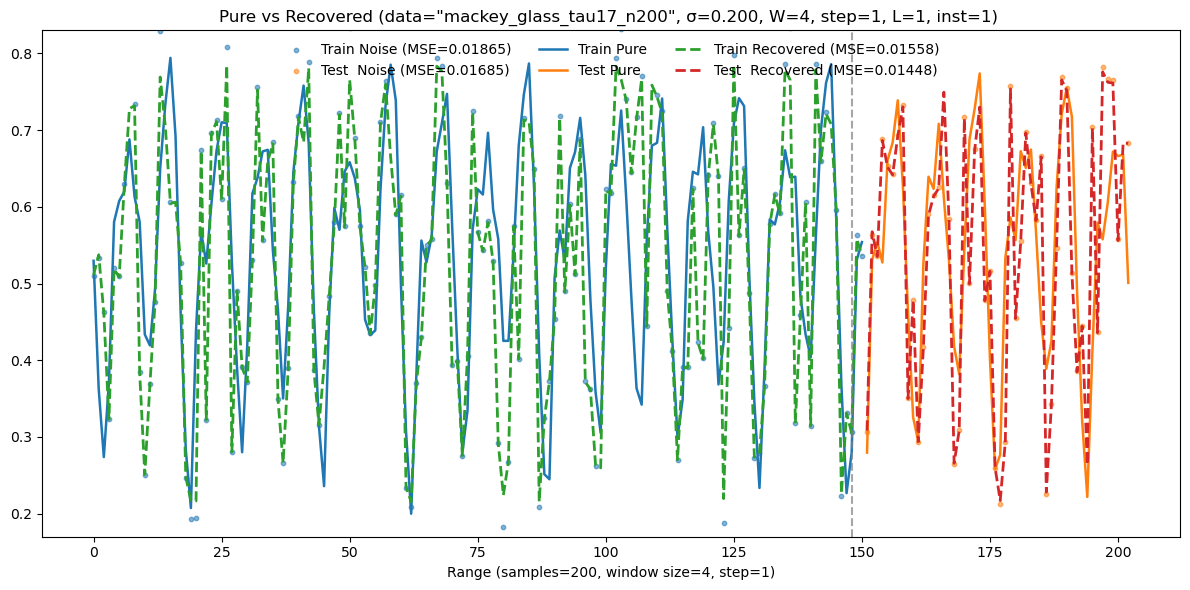

[Series-avg] TRAIN pure vs noisy vs recovered = 0.01865179, 0.01558249
[Series-avg] TEST  pure vs noisy vs recovered = 0.01684969, 0.01447617

=== Final plot for L=3, inst=1 ===


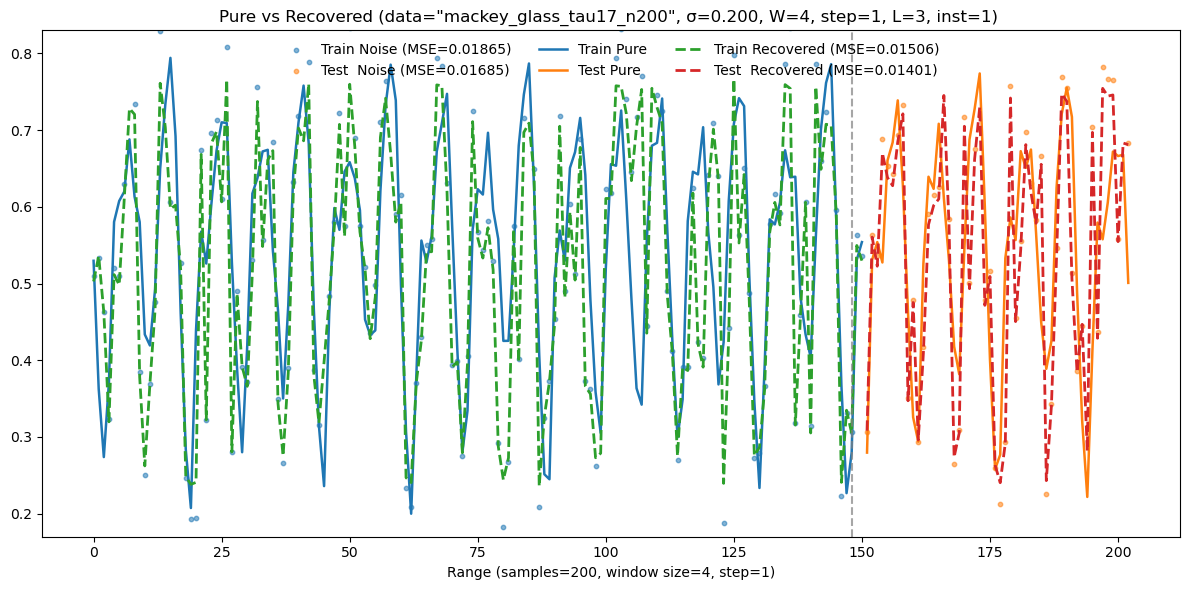

[Series-avg] TRAIN pure vs noisy vs recovered = 0.01865179, 0.01505762
[Series-avg] TEST  pure vs noisy vs recovered = 0.01684969, 0.01401120


In [30]:
# ===============================
# Cell 9 — final plots
# ===============================
import numpy as np
import matplotlib.pyplot as plt

def _windows_from_seed(y_vec, sigma, seed):
    """Noise the whole series once, then window + split."""
    y_noisy = ts_add_noise(
        y_vec, noise=sigma, noise_type='normal', clip=False,
        range_low=scale_low, range_high=scale_high, seed=seed
    )
    win_clean = ts_wind_make(y_vec,   wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(win_clean))])
    _, tr_clean, _, te_clean = ts_wind_split(X_ts, win_clean, split)
    _, tr_noisy, _, te_noisy = ts_wind_split(X_ts, win_noisy, split)
    return tr_clean, tr_noisy, te_clean, te_noisy

def _flatten_avg(windows):
    return ts_wind_flatten_avg(np.asarray(windows), wind_step)

def mentor_style_plot(instance_id, n_layers, noise_seed=None, title_note=""):
    # grab the run
    run = next(r for r in ALL_RUNS
               if r["instance_id"] == instance_id and r["n_layers"] == n_layers)
    phi = np.array(run["stage1"]["phi"])
    psi = np.array(run["stage3"]["psi"])

    # if not given, use the last Stage-3 seed (so it matches your "[Final TEST]" print)
    if noise_seed is None:
        eplen = len(run["stage3"]["hist_test_win_mse"])
        noise_seed = 88_000 + 100*instance_id + (eplen - 1)

    # denoiser bound to this (L, φ)
    denoise = stage3_qnodes(n_layers, phi)["denoiser_qnode_all"]

    # build windows for this seed
    tr_clean, tr_noisy, te_clean, te_noisy = _windows_from_seed(y, EVAL_SIGMA, noise_seed)

    # recover (window level) then flatten by averaging overlaps
    tr_rec = denoise_windows(psi, denoise, tr_noisy)
    te_rec = denoise_windows(psi, denoise, te_noisy)

    tr_pure  = _flatten_avg(tr_clean)
    te_pure  = _flatten_avg(te_clean)
    tr_noi   = _flatten_avg(tr_noisy)
    te_noi   = _flatten_avg(te_noisy)
    tr_hat   = _flatten_avg(tr_rec)
    te_hat   = _flatten_avg(te_rec)

    def _mse(a, b):
        a = np.asarray(a); b = np.asarray(b)
        return float(np.mean((a - b) ** 2))

    mse_tr_noise = _mse(tr_pure, tr_noi)
    mse_te_noise = _mse(te_pure, te_noi)
    mse_tr_hat   = _mse(tr_pure, tr_hat)
    mse_te_hat   = _mse(te_pure, te_hat)

    # x-axes (continuous train→test), vertical split for readability
    x_tr = np.arange(len(tr_pure))
    x_te = np.arange(len(tr_pure), len(tr_pure) + len(te_pure))
    x_split = len(tr_pure) - (wind_size - wind_step)

    # ---- plot ----
    plt.figure(figsize=(12, 6))
    # noisy dots
    plt.scatter(x_tr, tr_noi, s=10, alpha=0.55, label=f"Train Noise (MSE={mse_tr_noise:0.5f})")
    plt.scatter(x_te, te_noi, s=10, alpha=0.55, label=f"Test  Noise (MSE={mse_te_noise:0.5f})")
    # pure solid
    plt.plot(x_tr, tr_pure, linewidth=1.8, label="Train Pure")
    plt.plot(x_te, te_pure, linewidth=1.8, label="Test Pure")
    # recovered dashed
    plt.plot(x_tr, tr_hat, linestyle="--", linewidth=2.0, label=f"Train Recovered (MSE={mse_tr_hat:0.5f})")
    plt.plot(x_te, te_hat, linestyle="--", linewidth=2.0, label=f"Test  Recovered (MSE={mse_te_hat:0.5f})")

    plt.axvline(x_split, color="grey", linestyle="--", alpha=0.7)
    plt.ylim(scale_low - 0.05*(scale_high - scale_low),
             scale_high + 0.05*(scale_high - scale_low))
    plt.xlabel(f'Range (samples={len(y)}, window size={wind_size}, step={wind_step})')
    plt.title(
        f'Pure vs Recovered (data="{DATA_ID}", σ={EVAL_SIGMA:.3f}, '
        f'W={wind_size}, step={wind_step}, L={n_layers}, inst={instance_id}) {title_note}'
    )
    plt.legend(loc="upper center", ncol=3, frameon=False)
    plt.tight_layout()
    plt.show()

    # clean numeric summary
    print(f"[Series-avg] TRAIN pure vs noisy vs recovered = {mse_tr_noise:0.8f}, {mse_tr_hat:0.8f}")
    print(f"[Series-avg] TEST  pure vs noisy vs recovered = {mse_te_noise:0.8f}, {mse_te_hat:0.8f}")

# --- Make the plots for your two runs (L=1 and L=3, inst=1) ---
for L in LAYER_OPTIONS:
    if any(r["n_layers"] == L and r["instance_id"] == INSTANCE_IDS[0] for r in ALL_RUNS):
        print(f"\n=== Final plot for L={L}, inst={INSTANCE_IDS[0]} ===")
        mentor_style_plot(INSTANCE_IDS[0], L)

In [22]:
# ===========================
# Cell T1 — Scoring windows
# ===========================
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg, ts_add_noise

SCORE_SEED = 2024  # pick a fixed seed for reporting/plots

def build_scoring_windows(y_vec, sigma, seed, wind_size, wind_step, split):
    # one noise vector for the entire series (mentor style)
    y_noisy = ts_add_noise(y_vec, noise=sigma, noise_type='normal', clip=False,
                           range_low=scale_low, range_high=scale_high, seed=seed)
    # windowize clean and noisy the same way
    y_pure_win  = ts_wind_make(y_vec,   wind_size, wind_step)
    y_noisy_win = ts_wind_make(y_noisy, wind_size, wind_step)
    # split by order (mentor’s helper keeps alignment)
    X_ts = np.array([i*wind_step for i in range(len(y_pure_win))])
    X_tr, y_tr_pure, X_te, y_te_pure   = ts_wind_split(X_ts, y_pure_win,  split)
    X_tr, y_tr_noisy, X_te, y_te_noisy = ts_wind_split(X_ts, y_noisy_win, split)
    return (y_tr_pure, y_tr_noisy, y_te_pure, y_te_noisy)

y_train_pure_win, y_train_noisy_win, y_test_pure_win, y_test_noisy_win = \
    build_scoring_windows(y, EVAL_SIGMA, SCORE_SEED, wind_size, wind_step, split)

# flattened (“series-averaged”) versions for plotting/metrics
y_train_pure_flat  = ts_wind_flatten_avg(y_train_pure_win,  wind_step)
y_test_pure_flat   = ts_wind_flatten_avg(y_test_pure_win,   wind_step)
y_train_noisy_flat = ts_wind_flatten_avg(y_train_noisy_win, wind_step)
y_test_noisy_flat  = ts_wind_flatten_avg(y_test_noisy_win,  wind_step)


=== Results for L=1, inst=1 ===
[Series-avg] TRAIN pure vs noisy vs recovered = 0.01308084, 0.01111560
[Series-avg] TEST  pure vs noisy vs recovered = 0.01711965, 0.01379928
[Window-merged] TRAIN pure vs noisy vs recovered = 0.01290000, 0.01093785
[Window-merged] TEST  pure vs noisy vs recovered = 0.01763848, 0.01413679


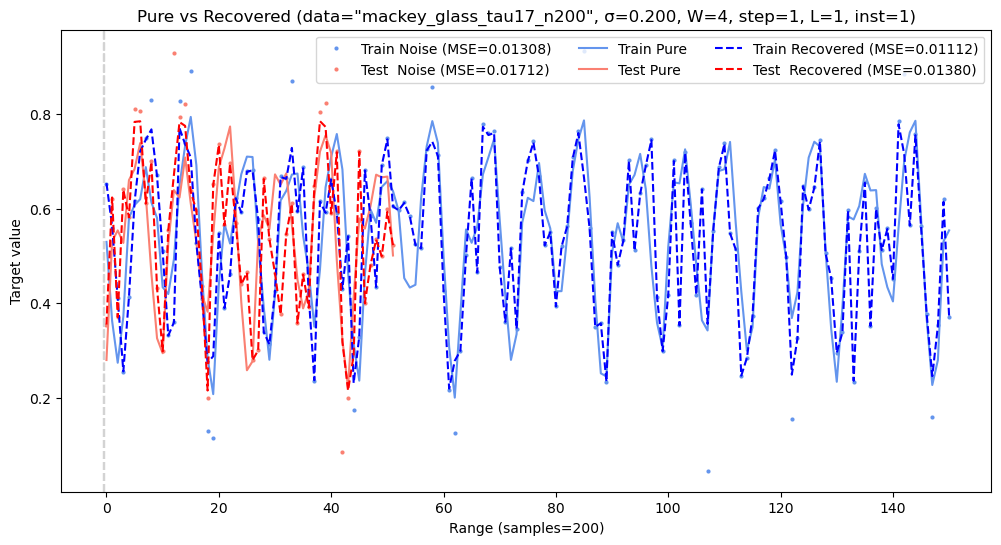


=== Results for L=3, inst=1 ===
[Series-avg] TRAIN pure vs noisy vs recovered = 0.01308084, 0.01082701
[Series-avg] TEST  pure vs noisy vs recovered = 0.01711965, 0.01354477
[Window-merged] TRAIN pure vs noisy vs recovered = 0.01290000, 0.01071514
[Window-merged] TEST  pure vs noisy vs recovered = 0.01763848, 0.01384336


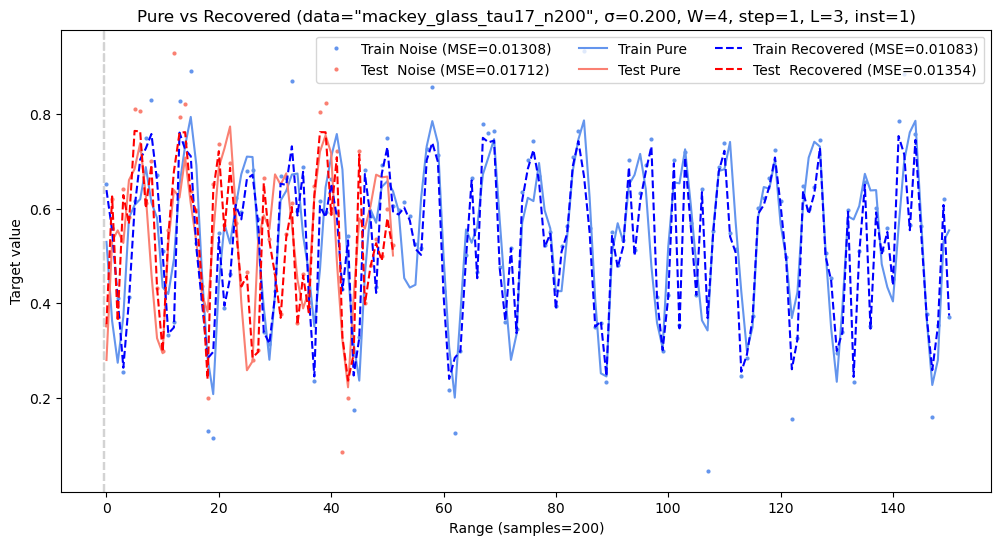

In [23]:
# === Evaluate exactly (L=1, inst=1) and (L=3, inst=1) ===
EVAL_PAIRS = [(1, 1), (3, 1)]  # (layers, instance)

def _pick_run(runs, L, inst):
    for r in runs:
        if r['n_layers'] == L and r['instance_id'] == inst:
            return r
    raise ValueError(f"No run found for L={L}, inst={inst}")

def denoise_windows(params, denoise_node, windows_noisy):
    outs = []
    for w in windows_noisy:
        zD = np.array(denoise_node(params, w))
        v_hat = np.array(Z_to_values_autograd(zD))
        outs.append(v_hat)
    return np.stack(outs)

from sklearn.metrics import mean_squared_error as mse

for EVAL_LAYERS, EVAL_INST in EVAL_PAIRS:
    sel = _pick_run(ALL_RUNS, EVAL_LAYERS, EVAL_INST)
    phi = sel['stage1']['phi']
    psi = sel['stage3']['psi']

    handles   = stage3_qnodes(EVAL_LAYERS, phi)
    denoise_q = handles['denoiser_qnode_all']

    # reconstruct windows
    pred_train_from_noisy_win = denoise_windows(psi, denoise_q, y_train_noisy_win)
    pred_test_from_noisy_win  = denoise_windows(psi, denoise_q, y_test_noisy_win)

    # series-averaged
    pred_train_from_noisy_flat = ts_wind_flatten_avg(pred_train_from_noisy_win, wind_step)
    pred_test_from_noisy_flat  = ts_wind_flatten_avg(pred_test_from_noisy_win,  wind_step)

    # metrics — series-averaged
    mse_train_pure_vs_noisy_sa = mse(y_train_pure_flat, y_train_noisy_flat)
    mse_train_pure_vs_rec_sa   = mse(y_train_pure_flat, pred_train_from_noisy_flat)
    mse_test_pure_vs_noisy_sa  = mse(y_test_pure_flat,  y_test_noisy_flat)
    mse_test_pure_vs_rec_sa    = mse(y_test_pure_flat,  pred_test_from_noisy_flat)

    # metrics — window-merged
    def _mse_win(true_w, pred_w):
        return float(np.mean((np.asarray(true_w) - np.asarray(pred_w))**2))
    mse_train_pure_vs_noisy_wm = _mse_win(y_train_pure_win, y_train_noisy_win)
    mse_train_pure_vs_rec_wm   = _mse_win(y_train_pure_win, pred_train_from_noisy_win)
    mse_test_pure_vs_noisy_wm  = _mse_win(y_test_pure_win,  y_test_noisy_win)
    mse_test_pure_vs_rec_wm    = _mse_win(y_test_pure_win,  pred_test_from_noisy_win)

    print(f"\n=== Results for L={EVAL_LAYERS}, inst={EVAL_INST} ===")
    print(f"[Series-avg] TRAIN pure vs noisy vs recovered = "
          f"{mse_train_pure_vs_noisy_sa:0.8f}, {mse_train_pure_vs_rec_sa:0.8f}")
    print(f"[Series-avg] TEST  pure vs noisy vs recovered = "
          f"{mse_test_pure_vs_noisy_sa:0.8f}, {mse_test_pure_vs_rec_sa:0.8f}")
    print(f"[Window-merged] TRAIN pure vs noisy vs recovered = "
          f"{mse_train_pure_vs_noisy_wm:0.8f}, {mse_train_pure_vs_rec_wm:0.8f}")
    print(f"[Window-merged] TEST  pure vs noisy vs recovered = "
          f"{mse_test_pure_vs_noisy_wm:0.8f}, {mse_test_pure_vs_rec_wm:0.8f}")

    # plot & save with suffix per pair
    multi_plot_flat_ts(
        [
            y_train_noisy_flat, y_test_noisy_flat,
            y_train_pure_flat,  y_test_pure_flat,
            pred_train_from_noisy_flat, pred_test_from_noisy_flat
        ],
        X_list=[0,0,0,0,0,0],
        colors=['none','none','cornflowerblue','salmon','blue','red'],
        marker_colors=['cornflowerblue','salmon','linen','linen','linen','linen'],
        labels=[
            f'Train Noise (MSE={mse_train_pure_vs_noisy_sa:0.5f})',
            f'Test  Noise (MSE={mse_test_pure_vs_noisy_sa:0.5f})',
            'Train Pure','Test Pure',
            f'Train Recovered (MSE={mse_train_pure_vs_rec_sa:0.5f})',
            f'Test  Recovered (MSE={mse_test_pure_vs_rec_sa:0.5f})'
        ],
        lines=['none','none','solid','solid','dashed','dashed'],
        markers=['.','.','none','none','none','none'],
        legend_cols=3,
        title=(f'Pure vs Recovered (data=\"{DATA_ID}\", σ={EVAL_SIGMA:0.3f}, '
               f'W={wind_size}, step={wind_step}, L={EVAL_LAYERS}, inst={EVAL_INST})'),
        xlabel=f'Range (samples={len(y)})',
        save_plot=f'{FIGURES_PATH}/{CASE_NAME}_{DATA_ID}/rec_L{EVAL_LAYERS}_inst{EVAL_INST}.eps'
    )

In [24]:
# ===========================
# Cell T2 — Reconstruction using trained half-QAE
# ===========================
# choose which trained run to visualize
EVAL_LAYERS = LAYER_OPTIONS[-1]   # e.g., 3 (or 1)
EVAL_INST   = INSTANCE_IDS[0]     # first instance by default

def _pick_run(runs, L, inst):
    for r in runs:
        if r['n_layers'] == L and r['instance_id'] == inst:
            return r
    # fallback: latest
    return runs[-1]

sel = _pick_run(ALL_RUNS, EVAL_LAYERS, EVAL_INST)
phi = sel['stage1']['phi']             # Stage-1 params (for fixed decoder)
psi = sel['stage3']['psi']             # best Stage-3 params

# build denoiser qnode from the selected run
handles = stage3_qnodes(EVAL_LAYERS, phi)
denoise_q = handles['denoiser_qnode_all']

def denoise_windows(params, denoise_node, windows_noisy):
    outs = []
    for w in windows_noisy:
        zD = np.array(denoise_node(params, w))
        # map Z → values in original scale
        v_hat = np.array(Z_to_values_autograd(zD))
        outs.append(v_hat)
    return np.stack(outs)

# reconstruct from NOISY windows (mentor compares pure vs recovered-from-noisy)
pred_train_from_noisy_win = denoise_windows(psi, denoise_q, y_train_noisy_win)
pred_test_from_noisy_win  = denoise_windows(psi, denoise_q, y_test_noisy_win)

# also build flattened (series-averaged) reconstructions
pred_train_from_noisy_flat = ts_wind_flatten_avg(pred_train_from_noisy_win, wind_step)
pred_test_from_noisy_flat  = ts_wind_flatten_avg(pred_test_from_noisy_win,  wind_step)

In [25]:
# ===========================
# Cell T3 — Metrics (window-merged & series-averaged)
# ===========================
from sklearn.metrics import mean_squared_error as mse

# series-averaged (mentor’s plotting preference)
mse_train_pure_vs_noisy_sa = mse(y_train_pure_flat, y_train_noisy_flat)
mse_train_pure_vs_rec_sa   = mse(y_train_pure_flat, pred_train_from_noisy_flat)
mse_test_pure_vs_noisy_sa  = mse(y_test_pure_flat,  y_test_noisy_flat)
mse_test_pure_vs_rec_sa    = mse(y_test_pure_flat,  pred_test_from_noisy_flat)

print(f"[Series-avg] TRAIN  pure vs noisy vs recovered = "
      f"{mse_train_pure_vs_noisy_sa:0.8f}, {mse_train_pure_vs_rec_sa:0.8f}")
print(f"[Series-avg] TEST   pure vs noisy vs recovered = "
      f"{mse_test_pure_vs_noisy_sa:0.8f}, {mse_test_pure_vs_rec_sa:0.8f}")

# window-merged (counts overlaps; closer to training loss semantics)
def _mse_win(true_w, pred_w):
    return float(np.mean((np.asarray(true_w) - np.asarray(pred_w))**2))

mse_train_pure_vs_noisy_wm = _mse_win(y_train_pure_win, y_train_noisy_win)
mse_train_pure_vs_rec_wm   = _mse_win(y_train_pure_win, pred_train_from_noisy_win)
mse_test_pure_vs_noisy_wm  = _mse_win(y_test_pure_win,  y_test_noisy_win)
mse_test_pure_vs_rec_wm    = _mse_win(y_test_pure_win,  pred_test_from_noisy_win)

print(f"[Window-merged] TRAIN pure vs noisy vs recovered = "
      f"{mse_train_pure_vs_noisy_wm:0.8f}, {mse_train_pure_vs_rec_wm:0.8f}")
print(f"[Window-merged] TEST  pure vs noisy vs recovered = "
      f"{mse_test_pure_vs_noisy_wm:0.8f}, {mse_test_pure_vs_rec_wm:0.8f}")

[Series-avg] TRAIN  pure vs noisy vs recovered = 0.01308084, 0.01082701
[Series-avg] TEST   pure vs noisy vs recovered = 0.01711965, 0.01354477
[Window-merged] TRAIN pure vs noisy vs recovered = 0.01290000, 0.01071514
[Window-merged] TEST  pure vs noisy vs recovered = 0.01763848, 0.01384336


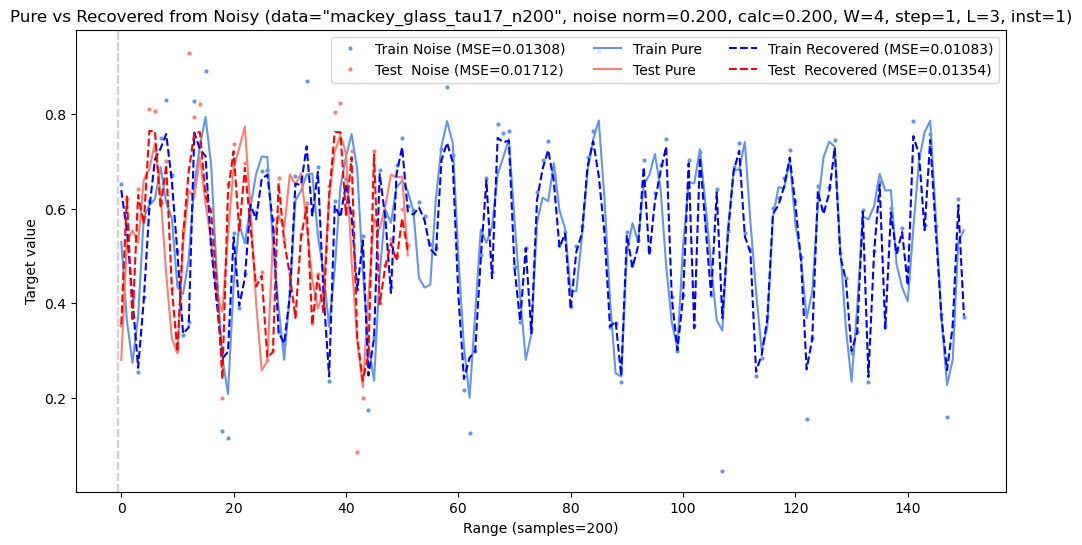

In [26]:
# ===========================
# Cell T4 — Plot
# ===========================
calc_noise = EVAL_SIGMA  # reported “calc” value for title

X_list = [0, 0, 0, 0, 0, 0]  # dummy Xs for multi_plot_flat_ts signature
y_list = [
    y_train_noisy_flat, y_test_noisy_flat,
    y_train_pure_flat,  y_test_pure_flat,
    pred_train_from_noisy_flat, pred_test_from_noisy_flat
]

print()
multi_plot_flat_ts(
    y_list, X_list=X_list,
    colors=['none','none','cornflowerblue','salmon','blue','red'],
    marker_colors=['cornflowerblue','salmon','linen','linen','linen','linen'],
    labels=[
        f'Train Noise (MSE={mse_train_pure_vs_noisy_sa:0.5f})',
        f'Test  Noise (MSE={mse_test_pure_vs_noisy_sa:0.5f})',
        'Train Pure','Test Pure',
        f'Train Recovered (MSE={mse_train_pure_vs_rec_sa:0.5f})',
        f'Test  Recovered (MSE={mse_test_pure_vs_rec_sa:0.5f})'
    ],
    lines=['none','none','solid','solid','dashed','dashed'],
    markers=['.','.','none','none','none','none'],
    legend_cols=3,
    title=(f'Pure vs Recovered from Noisy (data=\"{DATA_ID}\", '
           f'noise norm={EVAL_SIGMA:0.3f}, calc={calc_noise:0.3f}, '
           f'W={wind_size}, step={wind_step}, L={EVAL_LAYERS}, inst={EVAL_INST})'),
    xlabel=f'Range (samples={len(y)})',
    save_plot=f'{FIGURES_PATH}/{CASE_NAME}_{DATA_ID}/train_org_vs_recovered.eps'
)
print()

In [ ]:
# ===========================
# Cell 9 — Quick summary
# ===========================
import pandas as pd

rows = []
for r in ALL_RUNS:
    L = r["n_layers"]; inst = r["instance_id"]
    s3 = r["stage3"]
    rows.append(dict(
        instance_id=inst, n_layers=L,
        best_test_mse_win=np.min(s3["hist_test_win_mse"]),
        best_test_delta_win=np.max(s3["hist_test_delta_win"]),
        best_test_mse_series=np.min(s3["hist_test_ser_mse"]),
        best_test_delta_series=np.max(s3["hist_test_delta_ser"]),
    ))

df = pd.DataFrame(rows).sort_values(["n_layers","instance_id"]).reset_index(drop=True)
print(df)